In [1]:
# import
import csv
import math
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

from sklearn.cluster import KMeans

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)

%matplotlib inline

random.seed

<bound method Random.seed of <random.Random object at 0x10402cc18>>

In [74]:
kernel = 1.4 * RationalQuadratic(length_scale=0.08, alpha=2.1) + 1.0*ExpSineSquared(length_scale = 50, periodicity=1)
# for floor in range(0,5):
#     for building in range(0,3):
for floor in range(2,3):
    for building in range(0,1):
        
        ## Count the number of data points in building id & floor id
        data_num = 0
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num += 1
        print(data_num)
        ## if there are no data, continue to next floor 
        if (data_num == 0):
            continue
            
        ## Load data points in
        wifi_loc_time = np.zeros(shape = (data_num, 524))
        i=-1
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i = i+1
                if (i > data_num):
                    break
                # wifi
                wifi_loc_time[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time[i-1][-1] = np.array(row[-1])
        
        ## Sort by time stamp
        wifi_loc_time = wifi_loc_time[wifi_loc_time[:,-1].argsort()]
        
        ## List all users
        user_list = np.unique(wifi_loc_time[:, 522])
        user_num = len(user_list)
        print("On floor ", floor, " in building ", building, "there are ", user_num, " users.")
        
        ## Make grids
        grid_slice = 15
        grids = 2
        kmeans = KMeans(n_clusters = grids, random_state=0).fit(wifi_loc_time[:, 520:522])
        centers = kmeans.cluster_centers_
        dx = centers[0,0] - centers[1,0]
        dy = centers[0,1] - centers[1,1]
        R = math.sqrt(pow(centers[0,0] - centers[1,0], 2) + pow(centers[0,1] - centers[1,1], 2))
        cos = dx / R
        sin = - dy / R
        rotate = np.array([[cos, -sin],[sin, cos]])
        
        coordinates = np.zeros(shape=(len(wifi_loc_time[:,522]),2))
        
        for i in range(len(wifi_loc_time[:,522])):
            coordinates[i] = np.matmul(rotate, wifi_loc_time[i,520:522])
        
        
                                    ## max boundary , grid size, min boundary
        longitude_list = np.array([max(coordinates[:,0]), (max(coordinates[:,0])-min(coordinates[:,0]))/grid_slice\
                                   , min(coordinates[:,0])])
        latitude_list = np.array([max(coordinates[:,1]), (max(coordinates[:,1])-min(coordinates[:,1]))/grid_slice\
                                   , min(coordinates[:,1])])
        
        ## state tag = [grid_slice x grid_slice]
        state_tag = np.zeros(shape=(grid_slice, grid_slice), dtype=int)
        ## initialize to -1
        for i in range(grid_slice):
            for j in range(grid_slice):
                state_tag[i][j] = -1
        
        ## Record each user's number of location logs
        user_walking_num = np.zeros(shape=(user_num), dtype=int)
        for i in range(len(wifi_loc_time[:,522])):
            for user_index in range(user_num):
                if (wifi_loc_time[i, 522] == user_list[user_index]):
                    user_walking_num[user_index] += 1
        
        ## set the sequence length of observed walking tracks
        seq_window = 9
        total_batch_num = 0
        
        ## compute all users' walking sequences and add them as number of batches
        for num in user_walking_num:
            total_batch_num += math.floor(num/seq_window)
        print("total_batch_num: ",total_batch_num)
        
        batch_wifi = np.zeros((total_batch_num, seq_window, 520))
        batch_loc = np.zeros((total_batch_num, seq_window), dtype = int)
        
        ## tracking parameters
        state_count = 0
        ## cumulative graduation [# of batch of user1] + [# of batch of user2] [...]
        batch_num = 0
        iter_batch = 0
        iter_window = 0
        state_map_grid = {}
        
        for k in range(len(user_list)):
            print("User",k, " walking ", user_walking_num[k])
            
            ## [longitude, latitude, wifi]
            user_fp = np.zeros((user_walking_num[k], 2+520))
            batch_num += math.floor(user_walking_num[k]/seq_window)
            
            ## pick out the corresponding user's data
            user_i = 0
            for i in range(len(wifi_loc_time[:,522])):
                if (wifi_loc_time[i, 522] == user_list[k]):
                    user_fp[user_i, :2] = np.array(coordinates[i])
                    user_fp[user_i, 2:] = np.array(wifi_loc_time[i, :520])
                    user_i += 1
        
            for s in range(math.floor(user_walking_num[k]/seq_window) * seq_window):
                ## put state id
                i = int(math.ceil((user_fp[s][0] - longitude_list[2])/longitude_list[1]) - 1)
                j = int(math.ceil((user_fp[s][1] - latitude_list[2])/latitude_list[1]) - 1)
                if (i == -1):
                    i = 0
                elif (i >= grid_slice): 
                    i = grid_slice-1
                if (j == -1):
                    j = 0
                elif (j >= grid_slice): 
                    j = grid_slice-1
                if (state_tag[i][j] == -1):
                    ## apply GPs
                    gp = GaussianProcessRegressor(kernel=kernel,
                                          alpha=0.5)
                    grid_wifi_data = user_fp[s][2:].copy()
                    grid_loc_data = np.array([user_fp[s][0] - (longitude_list[1]*(float(i)+0.5) + longitude_list[2])\
                                              , user_fp[s][1] - (latitude_list[1]*(float(j)+0.5) + latitude_list[2])])
                    
                    state_tag[i][j] = state_count
                    state_map_grid[state_count] = [i,j, gp, grid_wifi_data, grid_loc_data]
                    state_count += 1
                else:
                    state_map_grid[state_tag[i][j]][3] = np.vstack((state_map_grid[state_tag[i][j]][3], user_fp[s][2:].copy()))
                    state_map_grid[state_tag[i][j]][4] = np.vstack((state_map_grid[state_tag[i][j]][4], \
                               np.array([user_fp[s][0] - (longitude_list[1]*(float(i)+0.5) + longitude_list[2])\
                                        , user_fp[s][1] - (latitude_list[1]*(float(j)+0.5) + latitude_list[2])])))
                    
                batch_wifi[iter_batch][iter_window] = user_fp[s][2:].copy()
                batch_loc[iter_batch,iter_window] = state_tag[i][j]

                
                if (iter_window == (seq_window-1)):
                    iter_window = 0
                    iter_batch = iter_batch + 1
                    if (iter_batch == (batch_num)):
                        break
                else:
                    iter_window = iter_window + 1
        print("Grid is ", grid_slice, "x", grid_slice, " ; the # of states is ", state_count)
        for s in range(state_count):
            print("State ", s, "; data points: ", state_map_grid[s][4].shape)
            state_map_grid[s][2] = state_map_grid[s][2].fit(state_map_grid[s][3], state_map_grid[s][4])
                    
        # Testing
        # extract data
        print("Validation...")
        data_num_v = 0
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num_v += 1

        print(data_num_v)
        if (data_num_v == 0):
            continue
        i = -1
        wifi_loc_time_v = np.zeros(shape = (data_num_v, 524))
        
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i += 1
                #if (i > data_num):
                #    break
                # wifi
                wifi_loc_time_v[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time_v[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time_v[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time_v[i-1][-1] = np.array(row[-1])
                
        wifi_loc_time_v = wifi_loc_time_v[wifi_loc_time_v[:,-1].argsort()]  
                
        batch_num = int(data_num_v/seq_window)
        print("Validating data ", batch_num)
        batch_wifi_v = np.zeros((batch_num + 1, seq_window, 520))
        batch_loc_v = np.zeros((batch_num + 1, seq_window), dtype = int)

        iter_window = 0
        iter_batch = 1
        
        map_distance = 0
        adjust_grid_num = 0
                               
        coordinates_v = np.zeros(shape=(len(wifi_loc_time_v[:,522]),2))
        
        for i in range(len(wifi_loc_time_v[:,522])):
            coordinates_v[i] = np.matmul(rotate, wifi_loc_time_v[i,520:522])

        for s in range(len(wifi_loc_time_v)):
            
            i = int(math.ceil((coordinates_v[s][0]-longitude_list[2])/longitude_list[1]) - 1)
            j = int(math.ceil((coordinates_v[s][1]-latitude_list[2])/latitude_list[1]) - 1)
            if (i < -1):
                i = 0
            elif (i >= grid_slice): 
                i = grid_slice-1
            if (j < 0):
                j = 0
            elif (j >= grid_slice): 
                j = grid_slice-1
            if (state_tag[i][j] == -1):
                adjust_grid_num+=1
                min_dist = np.zeros(shape=(state_count, 1))
                for x in range(state_count):
                    min_dist[x,0] = math.sqrt(pow((float(state_map_grid[x][0])+0.5)*longitude_list[1]+longitude_list[2] - coordinates_v[s][0],2)+\
                              pow((float(state_map_grid[x][1])+0.5)*latitude_list[1]+latitude_list[2] - coordinates_v[s][1],2))
                map_distance += np.min(min_dist)
                state_tag[i][j] = np.argmin(min_dist)
            
            batch_wifi_v[iter_batch][iter_window] = wifi_loc_time_v[s][:520]
            batch_loc_v[iter_batch,iter_window] = state_tag[i][j]
            if (iter_window == (seq_window-1)):
                iter_window = 0
                iter_batch = iter_batch + 1
                if (iter_batch == (batch_num)):
                    break
            else:
                iter_window = iter_window + 1  
        print("Grids need adjustment: ", adjust_grid_num)
        print("Base map distance is ", map_distance/data_num_v)
                
        model = ChainCRF()
        ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=80)            
        ssvm.fit(batch_wifi, batch_loc)
        
        pred_batch_v = ssvm.predict(batch_wifi_v)

        center_longitude_pred = 0
        center_latitude_pred = 0
        center_longitude_gt = 0
        center_latitude_gt = 0
        
        real_longitude = 0
        real_latitude = 0

        iter_test = 0
        
        gp_total_error = 0
        gp_window = np.zeros((seq_window))
        
        error_list = []
        ans_list_lo = []
        ans_list_la = []
        center_lo = []
        center_la = []
                                 
        inverse = np.linalg.inv(rotate)
        
        ## State prediction evaluation
        accuracy_state_tag = 0
        rmse_state_tag = 0
        rmse_grid_center = 0
        
        ## Ground-truth RMSE
        rmse_gt = 0
        error_list_gt = []
        total_error_gt = 0
        window_gt = np.zeros((seq_window))
        
        for i in range(1,batch_num+1):
            for j in range(seq_window):
                
                ## Offset produced by Gaussian Process
                ans = state_map_grid[pred_batch_v[i][j]][2].predict(batch_wifi_v[i][j].reshape(1,520))
                
                ## Offset produced by Ground-truth Gaussian Process
                ans_gt = state_map_grid[batch_loc_v[i][j]][2].predict(batch_wifi_v[i][j].reshape(1,520))
                
                center_longitude_pred = (float(state_map_grid[pred_batch_v[i][j]][0])+0.5)*longitude_list[1]
                center_latitude_pred = (float(state_map_grid[pred_batch_v[i][j]][1])+0.5)*latitude_list[1]
                center_longitude_gt = (float(state_map_grid[batch_loc_v[i][j]][0])+0.5)*longitude_list[1]
                center_latitude_gt = (float(state_map_grid[batch_loc_v[i][j]][1])+0.5)*latitude_list[1]
                
                real_longitude = wifi_loc_time_v[iter_test][520]
                real_latitude = wifi_loc_time_v[iter_test][521]
                
                ## State tagging part
                cen = np.matmul(inverse, np.array([center_longitude_pred+longitude_list[2],\
                                                   center_latitude_pred+latitude_list[2]]))
                center_lo.append(cen[0])
                center_la.append(cen[1])
                rmse_state_tag += math.sqrt(pow(cen[0] - real_longitude,2)\
                                         +pow(cen[1] - real_latitude,2))
                if (pred_batch_v[i][j] == batch_loc_v[i][j]):
                    accuracy_state_tag += 1
                ## RMSE between centers
                rmse_grid_center += math.sqrt(pow(center_longitude_pred - center_longitude_gt,2)\
                                              +pow(center_latitude_pred - center_latitude_gt,2))
                
                ## Add base and offset
                ans[0][0] += center_longitude_pred + longitude_list[2]
                ans[0][1] += center_latitude_pred + latitude_list[2]
                
                ans = np.matmul(inverse, np.array([ans[0][0], ans[0][1]]))

                ## RMSE between Final prediction result & real location
                error_list.append(math.sqrt(pow(ans[0] - real_longitude,2)+pow(ans[1] - real_latitude,2)))
                gp_total_error += error_list[-1]
                gp_window[j] += error_list[-1]
                ## store ans
                ans_list_lo.append(ans[0])
                ans_list_la.append(ans[1])
                
                ## Ground_truth
                ## Add base and offset
                ans_gt[0][0] += center_longitude_gt + longitude_list[2]
                ans_gt[0][1] += center_latitude_gt + latitude_list[2]
                
                ans_gt = np.matmul(inverse, np.array([ans_gt[0][0], ans_gt[0][1]]))

                ## RMSE between Final prediction result & real location
                error_list_gt.append(math.sqrt(pow(ans_gt[0] - real_longitude,2)+pow(ans_gt[1] - real_latitude,2)))
                total_error_gt += error_list_gt[-1]
                window_gt[j] += error_list_gt[-1]
                
                iter_test+=1
                

        print("\n\nState tagging error\n RMSE w.r.t. real location: ", rmse_state_tag/(batch_num*seq_window)\
             ,"\n RMSE between gt center and predicted center: ", rmse_grid_center/(batch_num*seq_window)\
             ,"\n Accuracy of state tagging: ", accuracy_state_tag/(batch_num*seq_window))
        
        print("\nGP part:\n RMSE: ", gp_total_error/(batch_num*seq_window)\
              ,"\n Windows:")
        for x in range(seq_window):
            print(" ", x, gp_window[x]/batch_num)
            
        print("\nGround-truth part:\n RMSE: ", total_error_gt/(batch_num*seq_window)\
              ,"\n Windows:")
        for x in range(seq_window):
            print(" ", x, window_gt[x]/batch_num)
        print("Finish\n")

1443
On floor  2  in building  0 there are  2  users.
total_batch_num:  159
User 0  walking  733
User 1  walking  710
Grid is  15 x 15  ; the # of states is  47
State  0 ; data points:  (40, 2)
State  1 ; data points:  (19, 2)
State  2 ; data points:  (20, 2)
State  3 ; data points:  (20, 2)
State  4 ; data points:  (40, 2)
State  5 ; data points:  (59, 2)
State  6 ; data points:  (39, 2)
State  7 ; data points:  (19, 2)
State  8 ; data points:  (20, 2)
State  9 ; data points:  (39, 2)
State  10 ; data points:  (29, 2)
State  11 ; data points:  (20, 2)
State  12 ; data points:  (60, 2)
State  13 ; data points:  (39, 2)
State  14 ; data points:  (48, 2)
State  15 ; data points:  (40, 2)
State  16 ; data points:  (12, 2)
State  17 ; data points:  (19, 2)
State  18 ; data points:  (20, 2)
State  19 ; data points:  (55, 2)
State  20 ; data points:  (20, 2)
State  21 ; data points:  (48, 2)
State  22 ; data points:  (20, 2)
State  23 ; data points:  (20, 2)
State  24 ; data points:  (29, 2)

(array([17.,  7.,  8.,  7.,  5.,  3.,  2.,  1.,  6.,  6., 13.,  6.,  4.,
         9.,  3.,  1.,  0.,  1.,  2.,  1.,  9.,  4.,  2.,  5.,  2.,  1.,
         2.,  1.,  1.,  5.,  4.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,
         2.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  2.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.14333175,  0.78814922,  1.43296668,  2.07778415,  2.72260161,
         3.36741908,  4.01223654,  4.65705401,  5.30187147,  5.94668894,
         6.5915064 ,  7.23632387,  7.88114134,  8.5259588 ,  9.17077627,
         9.81559373, 10.4604112 , 11.10522866, 11.75004613, 12.39486359,
        13.03968106, 13.68449852, 14.32931599, 14.97413345, 15.61895092,
        16.26376838, 16.90858585, 17.55340331, 18.19822078, 18.843038

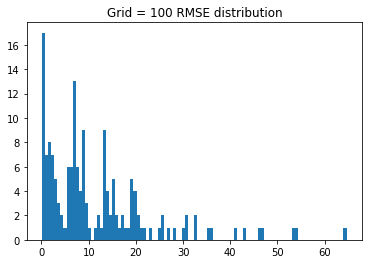

In [73]:
n_bins = 100
plt.title("Grid = "+str(grid_slice)+" RMSE distribution")
plt.hist(error_list, bins=n_bins)
# plt.show()
# plt.hist(error_list, bins=n_bins, cumulative=True, histtype='step')
# plt.show()

The # of validation points is  162
7 Predicted state  18 Gt state  45  point 12
8 Predicted state  18 Gt state  45  point 13
11 Predicted state  18 Gt state  45  point 22
21 Predicted state  17 Gt state  45  point 57
22 Predicted state  10 Gt state  45  point 58
23 Predicted state  0 Gt state  45  point 59
27 Predicted state  0 Gt state  45  point 63
28 Predicted state  17 Gt state  45  point 64


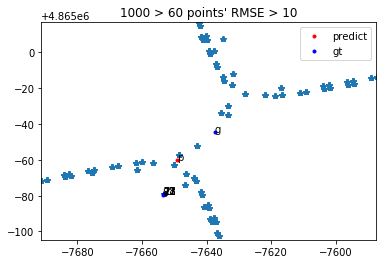

In [85]:
it = 0
num_of_pnt = 0
axes = plt.gca()
axes.set_xlim([min(min(wifi_loc_time_v[:,520]), min(ans_list_lo)),\
               max(max(wifi_loc_time_v[:,520]), max(ans_list_lo))])
axes.set_ylim([min(min(wifi_loc_time_v[:,521]), min(ans_list_la)),\
               max(max(wifi_loc_time_v[:,521]), max(ans_list_la))])
axes.annotate("p", xy=(ans_list_lo[it], ans_list_la[it]))
axes.annotate("g", xy=(wifi_loc_time_v[it,520], wifi_loc_time_v[it,521]))
plt.plot(ans_list_lo[it], ans_list_la[it], 'r.', label="predict")
plt.plot(wifi_loc_time_v[it,520], wifi_loc_time_v[it,521], 'b.', label="gt")
thr = 10
up = 1000
easy_to_be_other = []
plt.plot(wifi_loc_time[:,520], wifi_loc_time[:,521], '*')
print("The # of validation points is ", len(error_list))
for i in range(1,batch_num+1):
    for j in range(seq_window):
        if (error_list[it]>thr and error_list[it]<up):
            if (pred_batch_v[i][j] == batch_loc_v[i][j]):
                print(num_of_pnt, "Predicted state ", pred_batch_v[i][j], "Gt state ", batch_loc_v[i][j], " point", it)
            else:
                easy_to_be_other.append(batch_loc_v[i][j])

#             print(num_of_pnt, "Predicted state ", pred_batch_v[i][j], "Gt state ", batch_loc_v[i][j], " point", it)
            #axes.annotate(str(num_of_pnt), xy=(ans_list_lo[it], ans_list_la[it]))
            if (batch_loc_v[i][j] == 45):
                print(num_of_pnt, "Predicted state ", pred_batch_v[i][j], "Gt state ", batch_loc_v[i][j], " point", it)
                axes.annotate(str(num_of_pnt), xy=(wifi_loc_time_v[it,520], wifi_loc_time_v[it,521]))
            #plt.plot(ans_list_lo[it], ans_list_la[it], 'r.')
                plt.plot(wifi_loc_time_v[it,520], wifi_loc_time_v[it,521], 'b.')
            #plt.plot(center_lo[it], center_la[it], 'go')
            num_of_pnt += 1
        it += 1
plt.title(str(up)+" > "+str(num_of_pnt)+" points' RMSE > "+str(thr))
plt.legend()

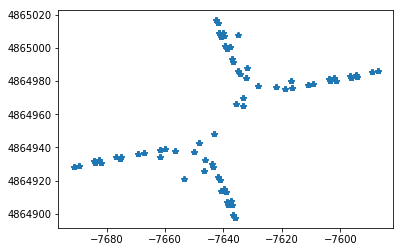

In [11]:
plt.plot(wifi_loc_time[:,520], wifi_loc_time[:,521], '*')

(array([8., 4., 1., 0., 1., 0., 3., 0., 3., 2., 0., 0., 1., 0., 1., 2., 1.,
        2., 0., 0., 3., 2., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 6., 0.,
        2., 0., 0., 0., 2., 2., 1., 0., 0., 0., 0., 2., 7.]),
 array([ 0.        ,  0.95744681,  1.91489362,  2.87234043,  3.82978723,
         4.78723404,  5.74468085,  6.70212766,  7.65957447,  8.61702128,
         9.57446809, 10.53191489, 11.4893617 , 12.44680851, 13.40425532,
        14.36170213, 15.31914894, 16.27659574, 17.23404255, 18.19148936,
        19.14893617, 20.10638298, 21.06382979, 22.0212766 , 22.9787234 ,
        23.93617021, 24.89361702, 25.85106383, 26.80851064, 27.76595745,
        28.72340426, 29.68085106, 30.63829787, 31.59574468, 32.55319149,
        33.5106383 , 34.46808511, 35.42553191, 36.38297872, 37.34042553,
        38.29787234, 39.25531915, 40.21276596, 41.17021277, 42.12765957,
        43.08510638, 44.04255319, 45.        ]),
 <a list of 47 Patch objects>)

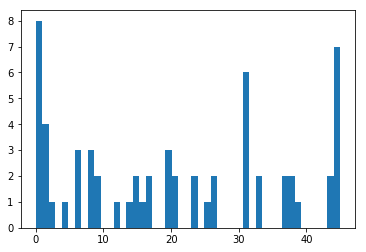

In [65]:
plt.hist(easy_to_be_other, bins=47)

In [34]:
print(len(easy_to_be_other))

69


In [86]:
longitude_list

array([-4.24044344e+06,  6.76277692e+00, -4.24054488e+06])

In [87]:
latitude_list

array([-2.38451750e+06,  4.25255553e+00, -2.38458129e+06])